<a href="https://colab.research.google.com/github/ChristineLong/NN_keras/blob/main/audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cash App Take home assignment

Since I cannot use BI's AWS account to complete this take home assignment, I used google colab to complete.

## Packages and configurations

Configure

In [ ]:
# mount google drive for raw files
from google.colab import drive
drive.mount('/content/drive')  #Please check whether the correct audio files are in your google drive before mounting

# set random seed to ensure reproducibility using pre-trained model
import random
random.seed(0)     

Mounted at /content/drive


In [ ]:
# Set to True if we are in colaboratory of False elsewere
colaboratory = True

if colaboratory:
    # Load the calc module
    !rm calc.*
    !wget https://raw.githubusercontent.com/R6500/Python-bits/master/Modules/calc.py

#Import the module
import calc

--2020-12-15 03:07:07--  https://raw.githubusercontent.com/R6500/Python-bits/master/Modules/calc.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20524 (20K) [text/plain]
Saving to: ‘calc.py’

calc.py             100%[===================>]  20.04K  --.-KB/s    in 0.001s  

2020-12-15 03:07:07 (33.1 MB/s) - ‘calc.py’ saved [20524/20524]



Dependent packages

In [ ]:
import os
import numpy as np
import pandas as pd
from IPython.display import Audio
from IPython.display import clear_output
from scipy.io import wavfile

import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import json
import math
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import resample

## Data import and exploration

#### Unzip and store in current working directory

In [ ]:
!mkdir /content/drive/MyDrive/raw
!unzip 'drive/MyDrive/Dessa Cash Dataset.zip' -d /content/drive/MyDrive/raw

#### Exploration

Load a single example file to explore: 100-3

Sample rate: 44100 Hz
Total time: 3.0998866213151928 s


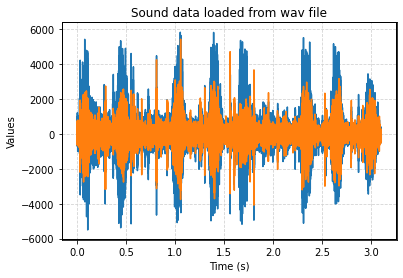

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


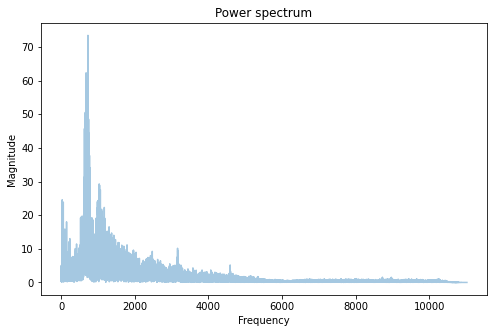

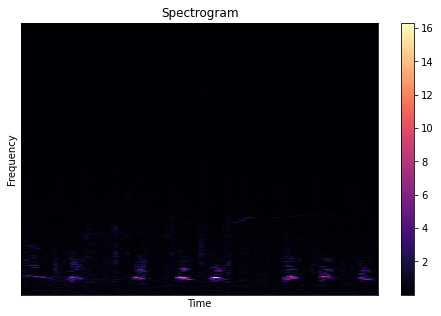

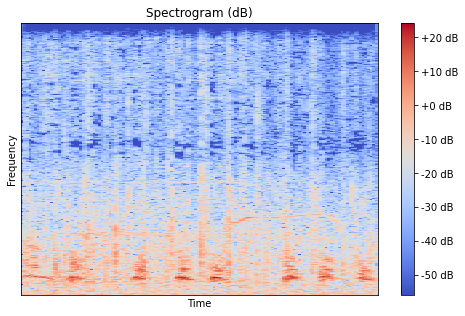

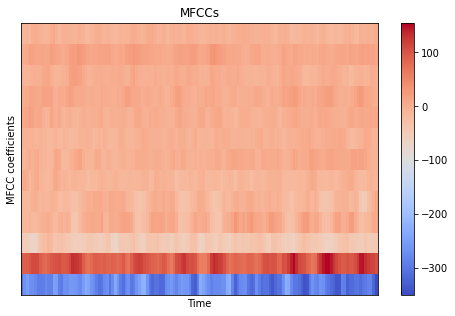

In [ ]:
FIG_SIZE = (8,5)
file = './drive/MyDrive/raw/Data/100-3.wav'

# load audio file with Librosa
signal, sample_rate = librosa.load(file, sr=22050)

#basic info
calc.setColaboratory(colaboratory)
data = wavfile.read(file)

framerate = data[0]
sounddata = data[1]
time      = np.arange(0,len(sounddata))/framerate

# Show basic information about the object
print('Sample rate:',framerate,'Hz')
print('Total time:',len(sounddata)/framerate,'s')

# Show the sound data
calc.plot11(time,sounddata,"Sound data loaded from wav file","Time (s)","Values")


# FFT -> power spectrum
# perform Fourier transform
fft = np.fft.fft(signal)

# calculate abs values on complex numbers to get magnitude
spectrum = np.abs(fft)

# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")


# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")


# MFCCs
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(signal, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()

As we can see from 100-3:
- The audio is around 4s, the videos are rather short, probably already clipped to contain target info. If futher segment the video, the target information may not be presented in some of the segments. Therefore no segmentation is needed;
- There are two types of audio, blue (larger amplitude) is background noise and orange (smaller amplitude) is bark. However, bark is actually the target info. If we denoising the audio, we might lose the target information. 

Overview of different types

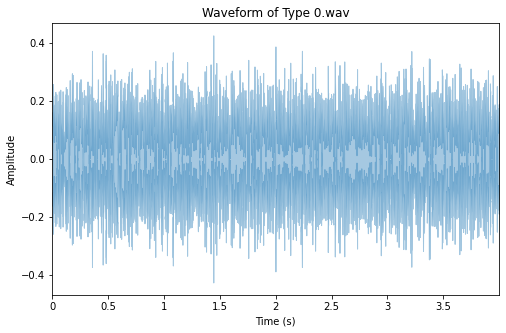

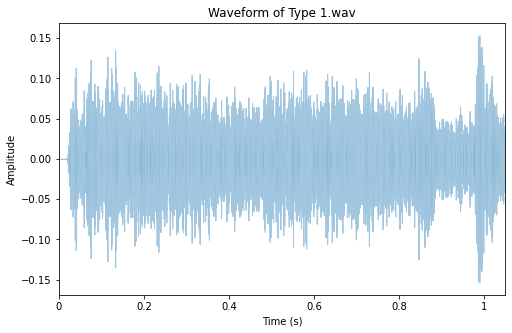

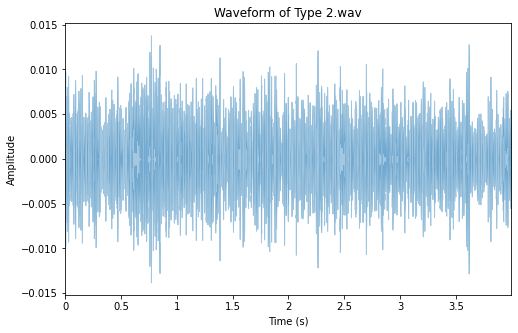

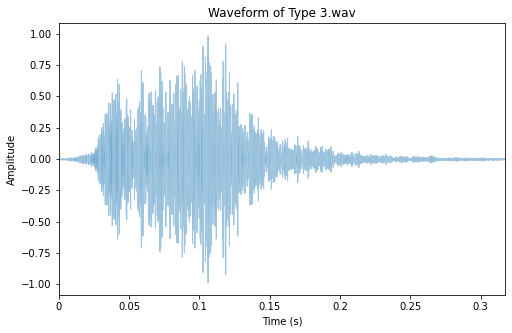

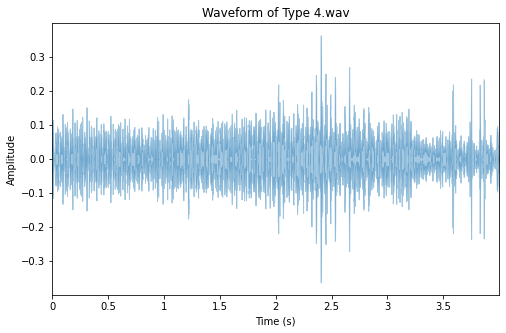

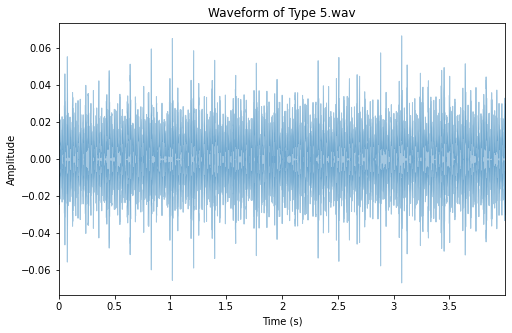

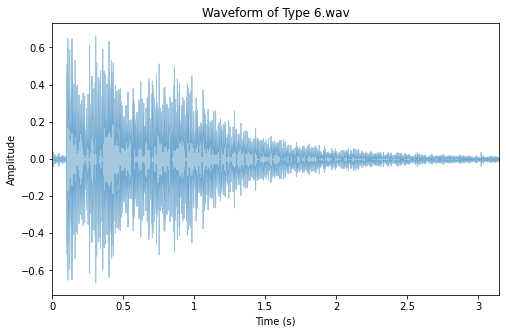

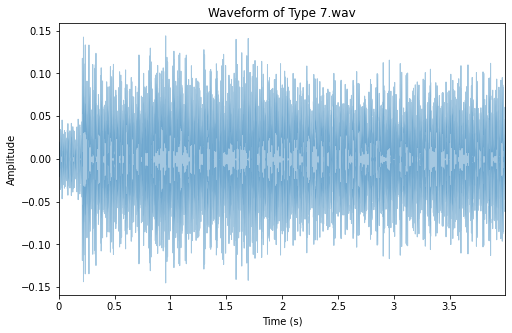

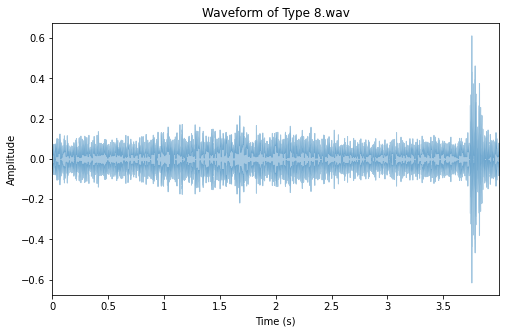

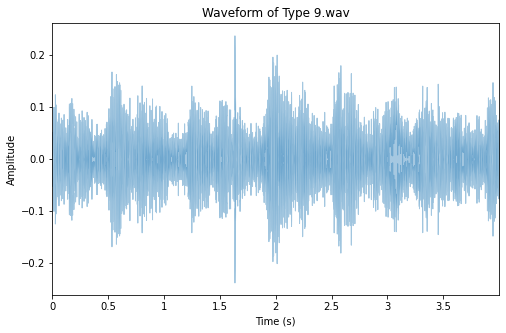

In [ ]:
# waveform for all type
FILES = ['30-0','10-1','7-2','0-3', '7194-4','1186-5','1000-6','171-7','115-8','99-9']
for file in FILES:
  file = './drive/MyDrive/raw/Data/'+ file + '.wav'
  signal, sample_rate = librosa.load(file, sr=22050)
  plt.figure(figsize=FIG_SIZE)
  librosa.display.waveplot(signal, sample_rate, alpha=0.4)
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude")
  plt.title("Waveform of Type "+str(file.split('-')[-1]))

Based on the exploration result, we can conclude that:
1. Denoising or not: As shown in exploration with 100-3, if we denoising the audio, we might lose the target information. Therefore, we do not denoising the raw data. Please note this is specific to this training data.
2. Segment or not: no segmentation is needed for this data, but segmentation is included so that code might be reused for non-clipped data. Here we set segment=1 to avoid segmentation.
3. Too short: some videos are <= 1s but still contain target info (such as bark or siren), so we shouldn't simply remove it;
4. Types: different types of data have different patterns, however some patterns are close to each other. This might lead to misclassification later.

## Modeling and Evaluation

### Model type:
1. Target info available: supervised learning
2. MLP vs. CNN vs. CRNN: Considering model performance, I prefer CNN and CRNN. But whether we need RNN is a problem. Some types of audio do not need RNN (bark, gunfire, etc.) as snipets are less sequential, but some types of audio (children speaking, music) are the opposite. Here I ran CRNN (CNN+LSTM) on this data. 

### Process:
1. For initial testing, use a subset of data (downsampling to N=200);
2. Try and adjust a few model structures and select the one that has best performance (low training and testing)
3. Use all data to:
  - Data augmentation: add gaussian noise to boost the sample size (eliminated due to colab RAM limit);
  - Split data into training, testing and validation sets to prevent information leak:
  - Tuning hyperparameters;
  - Fit final model and predict on testing data;
  - Evaluate model with accuracy, precision, recall and F1 score.
  - Visualize model results and intepret. 

#### Preprocess

##### Calculate MFCC

In [ ]:
DATASET_PATH = "./drive/MyDrive/raw/Data/"
JSON_PATH = "./drive/MyDrive/data_10.json"
SAMPLE_RATE = 44100
TRACK_DURATION = 4 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
trash = [] # store problematic filename. Here is ['.DS_Store'], unwanted

def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.
        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return: None
        """

    # dictionary to store labels and MFCCs
    data = {
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        for f in filenames:
          # save target label (i.e., last num of filename)
          try:
            target = int(f.split(".")[0].split("-")[-1])
          except:
            trash.append(f)
            continue
          # load audio file
          file_path = os.path.join(dirpath, f)
          signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

          # process all segments of audio file
          for d in range(num_segments):

              # calculate start and finish sample for current segment
              start = samples_per_segment * d
              finish = start + samples_per_segment

              # extract mfcc
              mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
              mfcc = mfcc.T

              # store only mfcc feature with expected number of vectors
              if len(mfcc) == num_mfcc_vectors_per_segment:
                  data["mfcc"].append(mfcc.tolist())
                  data["labels"].append(target)
                  print("{}, segment:{}".format(file_path, d+1))

      # save MFCCs to json file
    with open(json_path, "w") as fp:
      json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    save_mfcc(DATASET_PATH, JSON_PATH, num_segments=1)

In [ ]:
trash

['.DS_Store']

##### Check data balance and deal imbalanced issue

In [ ]:
with open(JSON_PATH, "r") as fp:
  data = json.load(fp)

  X = np.array(data["mfcc"])
  y = np.array(data["labels"])

pd.DataFrame(y).value_counts()

9    1000
0     997
2     976
5     961
8     897
4     805
7     804
3     675
1     203
6      16
dtype: int64

Other types are ok but Class 6 is way too few. 

Although there are many way to augment data for audio (see future work)

--> Then I chose to Use SMOTE to upsampling minority class: failed. SMOTE can only accept 2D and we have and need 3D for MFCC;

--> Use basic resampling: resample with sklearn to boost sample size due to the time limit.

In [ ]:
X[y==6].shape

(16, 345, 13)

In [ ]:

X_minority = X[y==6]
 
# Upsample minority class
X_minority_upsampled = resample(X_minority, 
                                replace=True,     # sample with replacement to match other classes
                                n_samples=300,
                                random_state=123) 
 
# Combine majority class with upsampled minority class
X_new = np.vstack([X, X_minority_upsampled])
y_new = np.hstack([y, [6]*X_minority_upsampled.shape[0]]) 
# Display new class counts
print(X_new.shape)
print(y_new.shape)
pd.DataFrame(y_new).value_counts()

(7634, 345, 13)
(7634,)


9    1000
0     997
2     976
5     961
8     897
4     805
7     804
3     675
6     316
1     203
dtype: int64

#### Build deep learning model

Trial and error in adjusting model structure:
- First use a CNN --> Overfitting and low accuracy --> need regularization
- --> Add dropout layer and regularizer --> Underfitting
- --> Add batch normalization and LSTM layers --> Better 
- --> proven hypothesis on sequential nature of the data (see discussion in model type) 
- --> Add TimeDistributed layer --> worse
- --> remove TimeDistributed layer, use CRNN but larger and deeper on complete training samples --> High performance

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 343, 11, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 172, 6, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 172, 6, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 170, 4, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 2, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 85, 2, 64)         256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 84, 1, 64)         1

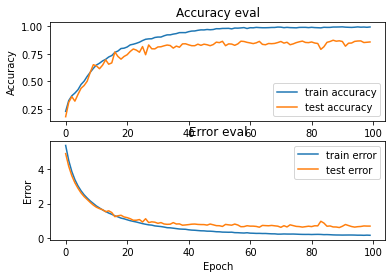

60/60 - 0s - loss: 0.7316 - accuracy: 0.8518

Test accuracy: 0.8517548441886902
Target: 3, Predicted label: [2]


In [ ]:
BATCH_SIZE = 64 
EPOCHS = 100

def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    # Upsample minority class
    X_minority = X[y==6] 
    X_minority_upsampled = resample(X_minority, 
                                    replace=True, 
                                    n_samples=300,
                                    random_state=123) 
    X_new = np.vstack([X, X_minority_upsampled])
    y_new = np.hstack([y, [6]*X_minority_upsampled.shape[0]]) 
    return X_new, y_new


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(JSON_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()
    
    # 1. CNN
    # 1st conv layer
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 2nd conv layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # 3rd conv layer
    model.add(Conv2D(64, (2, 2), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())

    # connect from conv to rnn
    model.add(Permute((2,1,3)))
    last_shape = model.layers[-1].output_shape
    model.add(Reshape((last_shape[1],last_shape[2]*last_shape[3])))
    
    # 2. RNN
    model.add(LSTM(32, kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),recurrent_dropout=0.5,return_sequences=True,go_backwards=False,activation='tanh'))
    model.add(LSTM(32, kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),recurrent_dropout=0.5,return_sequences=True,go_backwards=True,activation='tanh'))
    model.add(Dropout(0.25))
    
    #model.add(TimeDistributed(Dense(128,activation='relu')))
    #model.add(Dropout(0.5))
    
    #model.add(TimeDistributed(Dense(64,activation='relu')))
    #model.add(Dropout(0.5))
    

    # flatten output and feed it into dense layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # output layer
    model.add(Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy', # not one-hot encoded so sparse
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=BATCH_SIZE, epochs=EPOCHS)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]
    predict(model, X_to_predict, y_to_predict)

In [ ]:
model.save('RCNN.h5')
loaded = keras.models.load_model("RCNN.h5")

#### Final Result and Evaluation

##### Evaluation metrics

Accuracy on training and testing

In [ ]:
print(model.evaluate(X_train, y_train, verbose=2))
print(model.evaluate(X_test, y_test, verbose=2))

144/144 - 1s - loss: 0.1274 - accuracy: 0.9961
[0.12740319967269897, 0.9960698485374451]
60/60 - 0s - loss: 0.7316 - accuracy: 0.8518
[0.731565535068512, 0.8517548441886902]


High performance on both training and testing, showing no overfitting or underfitting.

##### Precision, recall, f1 score and weighted accuracy

In [ ]:
y_pred = loaded.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

30/30 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       285
           1       0.92      0.91      0.91        53
           2       0.66      0.79      0.72       209
           3       0.89      0.76      0.82       165
           4       0.94      0.87      0.90       199
           5       0.95      0.90      0.92       239
           6       0.98      1.00      0.99        65
           7       0.93      0.88      0.91       223
           8       0.95      0.91      0.93       228
           9       0.74      0.63      0.68       243

    accuracy                           0.85      1909
   macro avg       0.87      0.86      0.87      1909
weighted avg       0.86      0.85      0.85      1909



Precision and recall shows a low false positive and false negative ratio, contributes to a high F1 score.

##### Visualization

Use heatmap to visualize confusion matrix

Normalized confusion matrix
[[0.97 0.   0.01 0.   0.   0.   0.   0.   0.   0.01]
 [0.   0.91 0.   0.   0.02 0.   0.   0.   0.   0.08]
 [0.07 0.   0.79 0.02 0.01 0.01 0.   0.   0.   0.08]
 [0.01 0.   0.16 0.76 0.01 0.01 0.01 0.   0.01 0.04]
 [0.02 0.01 0.01 0.01 0.87 0.01 0.   0.04 0.   0.05]
 [0.05 0.   0.03 0.   0.   0.9  0.   0.   0.   0.02]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.05 0.   0.01 0.   0.02 0.01 0.   0.88 0.   0.01]
 [0.01 0.   0.03 0.02 0.   0.   0.   0.   0.91 0.03]
 [0.11 0.01 0.17 0.02 0.   0.01 0.   0.02 0.03 0.63]]


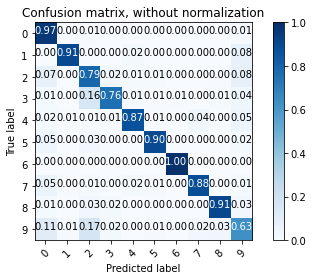

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, y_pred_bool,labels=list(range(10)))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(range(10)),
                      title='Confusion matrix, without normalization')

##### Interpretation


Based on both metrics and visualization, we can see that among different types:
1. Class 0, 1, 5, 6, 8 are precisely predicted. After listening to the audio, I found they are constant noise (maybe?),car beep, ship (I guess?), gunfire and siren. Those audio have very clear pattern and are easily classified;
2. Class 9 (music) have relatively low performance. This is probably because we focused more on CNN side than RNN (less layers, deleted timedistributed layer), in order to precisely classify other short sounds. However, music is rather sequential and probably need more RNN layers to be precisely classified.

## Future Work

If more time and resources were given, the analyses can be further improved in the following aspects:
1. Data preprocessing
  - Data Augmentation: there are multiple way to augment the training data (not augment audio) to make model more robut, such as add background noise / add gaussian noise / add gaussian noise with random Signal to Noise Ratio, or to mask certain frequency or blocks [1];
  - Trim leading and trailing silence;
  - Detect outliers and duplicates: certain clips might be too short to contain target info, or target info is masked by noise. There could also be duplicated audio introduced by error. Those need to be removed.  
2. Modeling: Instead of a simple CNN, we can try other types such as ResNet to achieve a higher accuracy;
3. Tuning hyperparameters: if included, total working time would exceed 8 hrs even with downsampling. So I just chose a few commonly used hyperparameters.
4. Comparison with existing model: we can apply the most commonly used pre-trained model as benchmark, and to show how our model perform comparing to it.

## Reference

[1] [SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition. Daniel S. Park, William Chan, Yu Zhang, Chung-Cheng Chiu, Barret Zoph, Ekin D. Cubuk, Quoc V. Le. Google Brain](https://arxiv.org/pdf/1904.08779.pdf)